<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>
<h3 style="text-align: center;"><b>Домашнее задание, GAN</b></h3>


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
!pip install torchsummary -q

In [2]:
import os
import gc
import random
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
import multiprocessing as mp
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
image_dir = '/kaggle/input/faces-dataset-small/faces_dataset_small'

batch_size = 128

EPOCH = 128
LRELU_S = 0.1
LEARN_RT=2e-4
BETAS=(0.5, 0.999)


IMG_SIZE = 64

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = '/kaggle/input/faces-dataset-small/faces_dataset_small'
paths = os.listdir(path)

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

def clear():
    torch.cuda.empty_cache()
    gc.collect()    

In [5]:
import os
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset

class ImageDataset(Dataset):
    def __init__(self, image_dir, target_size=IMG_SIZE):
        self.image_dir = image_dir
        self.size = target_size
        self.image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)] #тип List
        self.transform = Compose([
            Resize(size=self.size),
            #CenterCrop(size=self.size),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = self.transform(image)
        return image

def create_dataloader(image_dir, target_size=IMG_SIZE, batch_size=128):
    dataset = ImageDataset(image_dir, target_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:

dataset = ImageDataset(image_dir, IMG_SIZE)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    # Each batch is a tensor of shape (batch_size, channels, height, width)
    # For example, if batch_size=128, the shape will be (128, 3, 128, 128)
    print(batch.shape)

torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([71, 3, 64, 64])


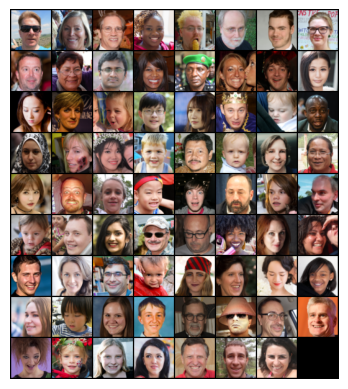

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Create a grid of images from the dataset
grid_images = make_grid(batch, nrow=8, normalize=True)

# Convert the grid tensor to a numpy array and transpose the dimensions
grid_images = grid_images.numpy().transpose((1, 2, 0))

# Display the grid of images
plt.imshow(grid_images)
plt.axis('off')
plt.show()


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

#### Была сделана попытка сгенерировать изображения 3х128х128 (классы Discriminator2, Generator2), однако время генерации сильно возрастает. 
#### В итоге, использованы классы Discriminator, Generator

#### Класс Дискриминатор для изображений 3x128х128

In [8]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.main = nn.Sequential(
            # B x 3 x 128 x 128
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.LeakyReLU(LRELU_S, inplace=True),
            
            # B x 64 x 64 x 64
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(LRELU_S, inplace=True),
            
            # B x 128 x 32 x 32
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(LRELU_S, inplace=True),
            
            # B x 256 x 16 x 16
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(LRELU_S, inplace=True),
            
            # B x 512 x 8 x 8
            nn.Conv2d(
                in_channels=512,
                out_channels=1024,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            
            # B x 1024 x 4 x 4
            nn.Conv2d(
                in_channels=1024,
                out_channels=1,
                kernel_size=(4, 4),
                #stride=(1, 1),
                #padding=(0, 0),
                #dilation=(1, 1),
                groups=1,
                bias=False
            ),
            
            # B x 1 x 1 x 1
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


#### Класс Дискриминатор для изображений 3x64х64

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # B x 3 x 64 x 64
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            
            # B x 64 x 32 x 32
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # B x 128 x 16 x 16
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # B x 256 x 8 x 8
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # B x 512 x 4 x 4
            nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=(4, 4),
                stride=(1, 1),
                padding=(0, 0),
                dilation=(1, 1),
                groups=1,
                bias=False
            ),
            
            # B x 1 x 1 x 1
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

#### Класс Генератор для изображений 128х128

In [10]:
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.main = nn.Sequential(
            # B x (img_size = 128) x 1 x 1  
            nn.ConvTranspose2d(
                in_channels=IMG_SIZE,
                out_channels=1024,  #out_channels=512,
                kernel_size=(4, 4),
                stride=(1, 1),
                padding=(0, 0),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=1024),  
            nn.ReLU(True),
            
            # B x 1024 x 4 x 4
            nn.ConvTranspose2d(
                in_channels=1024,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=512),  
            nn.ReLU(True),
            
            # B x 512 x 8 x 8     # B x 512 x 4 x 4
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=256),  
            nn.ReLU(True),
            
            # B x 256 x 16 x 16   # B x 256 x 8 x 8
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),
            
            # B x 128 x 32 x 32   # B x 128 x 16 x 16
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),
            
            # B x 64 x 64 x 64  # B x 64 x 32 x 32
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=3,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            
            # B x 3 x 128 x 128    # B x 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

#### Класс Генератор для изображений 3x64х64

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # B x (img_size = IMG_SIZE) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=IMG_SIZE,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(1, 1),
                padding=(0, 0),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            
            # B x 512 x 4 x 4
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            
            # B x 256 x 8 x 8
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),
            
            # B x 128 x 16 x 16
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),
            
            # B x 64 x 32 x 32
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=3,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                output_padding=(0, 0),
                groups=1,
                bias=False,
                dilation=(1, 1),
                padding_mode='zeros'
            ),
            
            # B x 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)

In [13]:
clear()

dis = Discriminator().to(device)
gen = Generator().to(device)

dis.apply(weights_init)
gen.apply(weights_init)

dis_opt = torch.optim.Adam(dis.parameters(), lr=LEARN_RT, betas=BETAS)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LEARN_RT, betas=BETAS)

loss_fn = nn.BCELoss(reduction='mean')

In [14]:
summary(dis, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12              [-1, 1, 5, 5]           8,192
          Flatten-13                   [-1, 25]               0
          Sigmoid-14                   

In [15]:
summary(gen, (IMG_SIZE, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

Epoch #1:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 10.7627, Discriminator loss: 0.6025


Epoch #2:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.4120, Discriminator loss: 0.5124


Epoch #3:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 6.2127, Discriminator loss: 1.6805


Epoch #4:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.3051, Discriminator loss: 0.5163


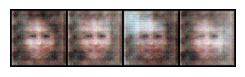

Epoch #5:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.9897, Discriminator loss: 0.6233


Epoch #6:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 7.8061, Discriminator loss: 1.2708


Epoch #7:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8222, Discriminator loss: 0.6539


Epoch #8:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.7293, Discriminator loss: 0.6761


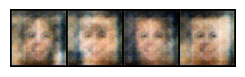

Epoch #9:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.4480, Discriminator loss: 3.7506


Epoch #10:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.1586, Discriminator loss: 0.5297


Epoch #11:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1064, Discriminator loss: 0.8329


Epoch #12:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.3635, Discriminator loss: 1.2619


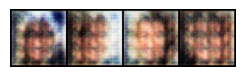

Epoch #13:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.1827, Discriminator loss: 1.2915


Epoch #14:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1151, Discriminator loss: 0.7879


Epoch #15:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 6.8892, Discriminator loss: 1.0199


Epoch #16:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.9116, Discriminator loss: 0.7545


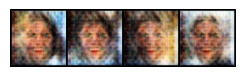

Epoch #17:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8031, Discriminator loss: 0.6605


Epoch #18:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.5656, Discriminator loss: 0.8163


Epoch #19:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9498, Discriminator loss: 0.9481


Epoch #20:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.4745, Discriminator loss: 0.7949


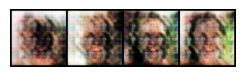

Epoch #21:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.6296, Discriminator loss: 0.9587


Epoch #22:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.0875, Discriminator loss: 1.0015


Epoch #23:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1300, Discriminator loss: 0.5697


Epoch #24:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.2901, Discriminator loss: 1.0585


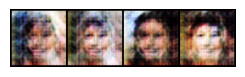

Epoch #25:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.5988, Discriminator loss: 1.3477


Epoch #26:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9907, Discriminator loss: 0.7798


Epoch #27:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.6225, Discriminator loss: 0.6905


Epoch #28:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.7701, Discriminator loss: 1.0411


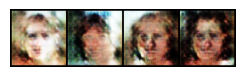

Epoch #29:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.2557, Discriminator loss: 0.7641


Epoch #30:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8517, Discriminator loss: 0.6794


Epoch #31:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2112, Discriminator loss: 1.0526


Epoch #32:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1533, Discriminator loss: 0.6651


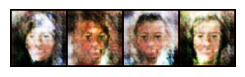

Epoch #33:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.2190, Discriminator loss: 0.7220


Epoch #34:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9661, Discriminator loss: 0.5920


Epoch #35:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1823, Discriminator loss: 0.5421


Epoch #36:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.0448, Discriminator loss: 0.5950


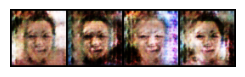

Epoch #37:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8958, Discriminator loss: 0.8540


Epoch #38:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9945, Discriminator loss: 0.9066


Epoch #39:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1410, Discriminator loss: 0.8673


Epoch #40:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.8600, Discriminator loss: 1.0848


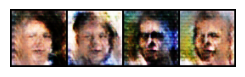

Epoch #41:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.0855, Discriminator loss: 0.5759


Epoch #42:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.5386, Discriminator loss: 0.7190


Epoch #43:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.1862, Discriminator loss: 0.6590


Epoch #44:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2649, Discriminator loss: 0.6933


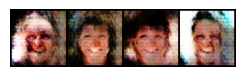

Epoch #45:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.0019, Discriminator loss: 0.8942


Epoch #46:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8464, Discriminator loss: 0.8595


Epoch #47:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.7819, Discriminator loss: 0.6318


Epoch #48:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.5810, Discriminator loss: 1.2716


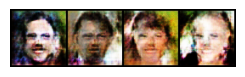

Epoch #49:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.8091, Discriminator loss: 0.7409


Epoch #50:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.3361, Discriminator loss: 1.3159


Epoch #51:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.3063, Discriminator loss: 0.9222


Epoch #52:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.2394, Discriminator loss: 0.6951


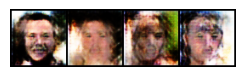

Epoch #53:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.2762, Discriminator loss: 0.6054


Epoch #54:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.6818, Discriminator loss: 0.9200


Epoch #55:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1195, Discriminator loss: 0.7051


Epoch #56:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 0.3165, Discriminator loss: 1.6991


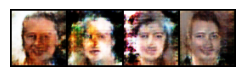

Epoch #57:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.4570, Discriminator loss: 0.5634


Epoch #58:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.5173, Discriminator loss: 0.7408


Epoch #59:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.5896, Discriminator loss: 1.0596


Epoch #60:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8768, Discriminator loss: 0.6799


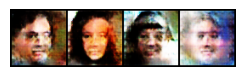

Epoch #61:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.4483, Discriminator loss: 1.3352


Epoch #62:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.6474, Discriminator loss: 0.6007


Epoch #63:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.3565, Discriminator loss: 0.6929


Epoch #64:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.7562, Discriminator loss: 0.8667


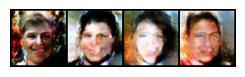

Epoch #65:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.6017, Discriminator loss: 0.8355


Epoch #66:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.2750, Discriminator loss: 0.6670


Epoch #67:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 6.4257, Discriminator loss: 1.7824


Epoch #68:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.9564, Discriminator loss: 0.8847


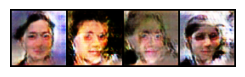

Epoch #69:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9563, Discriminator loss: 0.9577


Epoch #70:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2967, Discriminator loss: 0.6613


Epoch #71:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.5800, Discriminator loss: 0.7062


Epoch #72:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.3509, Discriminator loss: 0.8520


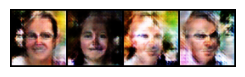

Epoch #73:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8458, Discriminator loss: 0.6807


Epoch #74:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.1408, Discriminator loss: 0.6105


Epoch #75:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.1702, Discriminator loss: 0.7497


Epoch #76:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.1597, Discriminator loss: 0.7287


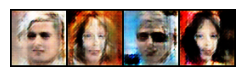

Epoch #77:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2540, Discriminator loss: 0.5877


Epoch #78:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.0976, Discriminator loss: 0.7804


Epoch #79:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.2452, Discriminator loss: 0.4885


Epoch #80:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.8294, Discriminator loss: 0.7491


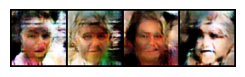

Epoch #81:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8683, Discriminator loss: 0.7428


Epoch #82:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2386, Discriminator loss: 0.7823


Epoch #83:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.5715, Discriminator loss: 0.7197


Epoch #84:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.4444, Discriminator loss: 1.0639


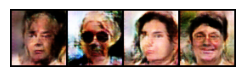

Epoch #85:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.8173, Discriminator loss: 0.8143


Epoch #86:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.4561, Discriminator loss: 0.8641


Epoch #87:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.8854, Discriminator loss: 0.8807


Epoch #88:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 0.9646, Discriminator loss: 1.0229


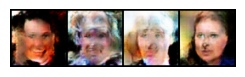

Epoch #89:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.5300, Discriminator loss: 0.6699


Epoch #90:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8150, Discriminator loss: 0.6513


Epoch #91:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.2987, Discriminator loss: 0.7684


Epoch #92:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.9058, Discriminator loss: 0.6222


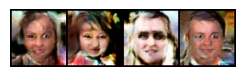

Epoch #93:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.4710, Discriminator loss: 2.0051


Epoch #94:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8458, Discriminator loss: 0.6872


Epoch #95:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.7742, Discriminator loss: 0.4741


Epoch #96:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.4906, Discriminator loss: 0.5159


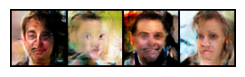

Epoch #97:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.3298, Discriminator loss: 0.6445


Epoch #98:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8211, Discriminator loss: 0.6885


Epoch #99:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.5280, Discriminator loss: 0.9845


Epoch #100:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.2478, Discriminator loss: 0.7362


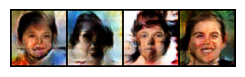

Epoch #101:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.9734, Discriminator loss: 0.5106


Epoch #102:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.9124, Discriminator loss: 0.5728


Epoch #103:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8109, Discriminator loss: 0.5947


Epoch #104:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.4889, Discriminator loss: 1.1557


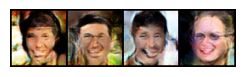

Epoch #105:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.3241, Discriminator loss: 0.5454


Epoch #106:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.2092, Discriminator loss: 0.6312


Epoch #107:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.5758, Discriminator loss: 0.8095


Epoch #108:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.6652, Discriminator loss: 0.6396


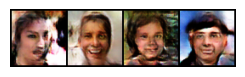

Epoch #109:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 6.4127, Discriminator loss: 0.9563


Epoch #110:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.5745, Discriminator loss: 0.7999


Epoch #111:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.0598, Discriminator loss: 0.4867


Epoch #112:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.8705, Discriminator loss: 0.6056


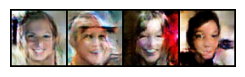

Epoch #113:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 6.3419, Discriminator loss: 1.2522


Epoch #114:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.6190, Discriminator loss: 0.7113


Epoch #115:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.2226, Discriminator loss: 0.4938


Epoch #116:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.3850, Discriminator loss: 0.5057


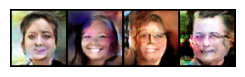

Epoch #117:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.9772, Discriminator loss: 0.4832


Epoch #118:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 1.7094, Discriminator loss: 0.7894


Epoch #119:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.1921, Discriminator loss: 0.8361


Epoch #120:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.1737, Discriminator loss: 0.5838


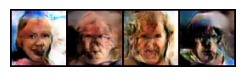

Epoch #121:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.0204, Discriminator loss: 0.5074


Epoch #122:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.8249, Discriminator loss: 0.5382


Epoch #123:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 4.6126, Discriminator loss: 0.6868


Epoch #124:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.4504, Discriminator loss: 0.6380


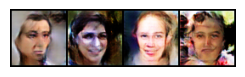

Epoch #125:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 3.0349, Discriminator loss: 0.6068


Epoch #126:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.1109, Discriminator loss: 0.6587


Epoch #127:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 2.7133, Discriminator loss: 0.4206


Epoch #128:   0%|          | 0/25 [00:00<?, ?it/s]

Generator loss: 5.6525, Discriminator loss: 1.5397


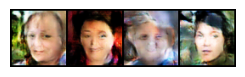

In [16]:
dis_loss_by_epoch = []
gen_loss_by_epoch = []

dis.train()
gen.train()

for epoch in range(EPOCH): #for epoch in range(100):
    
    dis_loss_epoch = list()
    gen_loss_epoch = list()
    
    for x in tqdm(dataloader, desc=f"Epoch #{1 + epoch}"):
        
        x = x.to(device)
        batch = x.shape[0]
        #print(x.shape)
        z = torch.randn(batch, IMG_SIZE, 1, 1).to(device)
        
        ones = torch.rand(batch, 1).to(device) * 0.05 + 0.95
        
        #print(ones.shape)
        zeros = torch.rand(batch, 1).to(device) * 0.05
        #print(zeros.shape)
        
        dis_opt.zero_grad()
        #print(dis(x).shape)
        #print(dis(gen(z).detach()).shape)
        dis_loss = loss_fn(dis(x), ones) + loss_fn(dis(gen(z).detach()), zeros)
        dis_loss.backward()
        dis_opt.step()

        dis_loss_epoch.append(dis_loss.item())
        
        ones = torch.rand(batch, 1).to(device) * 0.05 + 0.95
        
        gen_opt.zero_grad()
        gen_loss = loss_fn(dis(gen(z)), ones)
        gen_loss.backward()
        gen_opt.step()

        gen_loss_epoch.append(gen_loss.item())

    print(f"Generator loss: {gen_loss:.4f}, Discriminator loss: {dis_loss:.4f}")
    
    if (epoch + 1) % 4 == 0:
        z = torch.randn(4, IMG_SIZE, 1, 1).to(device)
        grid = vutils.make_grid(gen(z).detach().cpu(), nrow=4, normalize=True, scale_each=True)
        fig = plt.figure(figsize=(3, 0.75))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()
    
    dis_loss_by_epoch.append(np.mean(dis_loss_epoch))
    gen_loss_by_epoch.append(np.mean(gen_loss_epoch))

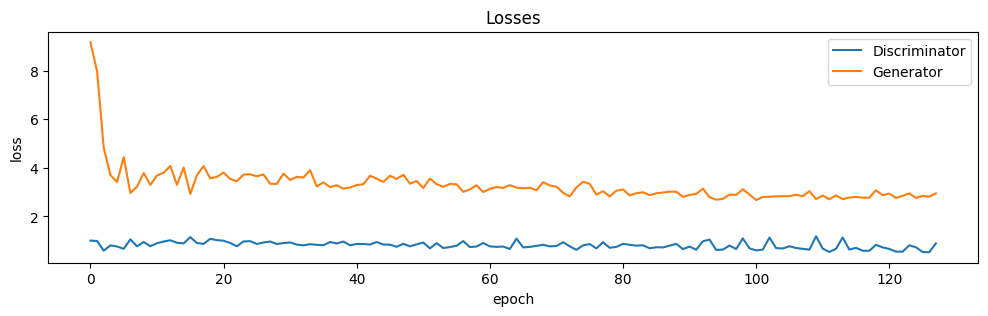

In [17]:
plt.figure(figsize=(12, 3))
plt.plot(dis_loss_by_epoch, '-')
plt.plot(gen_loss_by_epoch, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

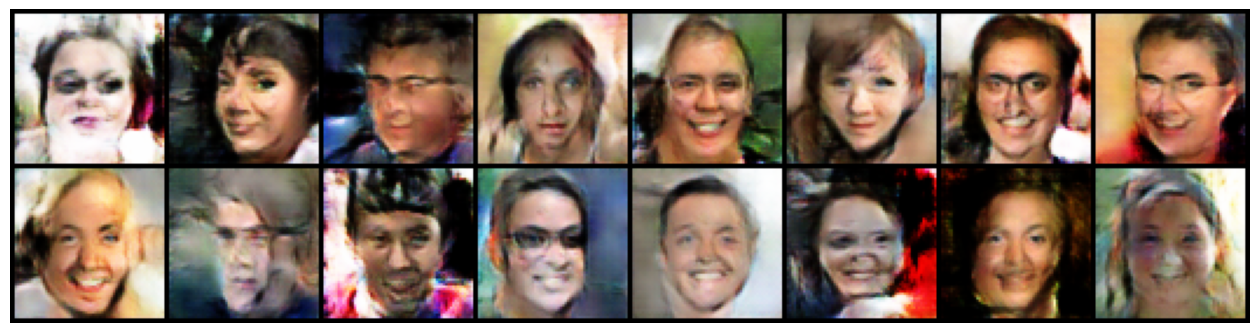

In [18]:
n_images = 16

z = torch.randn(n_images, IMG_SIZE, 1, 1).to(device)
z = gen(z).detach().cpu()

grid = vutils.make_grid(z, nrow=8, normalize=True, scale_each=True)
fig = plt.figure(figsize=(16,8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.show()

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [19]:
gen.eval()

real_images = torch.FloatTensor()
for x in dataloader:
    real_images = torch.cat([real_images, x], dim=0)
fake_images = gen(torch.randn(len(dataloader.dataset), IMG_SIZE, 1, 1).to(device)).detach().cpu()

real_fake_images = torch.cat([real_images, fake_images], dim=0).view(2 * len(dataloader.dataset), -1).numpy()

ones = torch.ones(len(dataloader.dataset))
zeros = torch.zeros(len(dataloader.dataset))

ones_zeros = torch.cat([ones, zeros], dim=0).numpy()

In [20]:
# 10 % of original data
p = torch.randperm(2 * len(dataloader.dataset))
p = p[:int(p.size(0) * 0.10)]

In [21]:
real_fake_images = real_fake_images[p]
ones_zeros = ones_zeros[p]

In [22]:
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=mp.cpu_count())
acc = []
for train_idx, test_idx in tqdm(LeaveOneOut().split(real_fake_images), total=len(real_fake_images)):
    X_train, X_test = real_fake_images[train_idx], real_fake_images[test_idx]
    y_train, y_test = ones_zeros[train_idx], ones_zeros[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

  0%|          | 0/628 [00:00<?, ?it/s]

In [23]:
np.mean(acc)

0.6767515923566879

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Хотелось бы 0.5, получили, что получили

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [24]:
%%time
tsne = TSNE(n_components=2, n_jobs=mp.cpu_count())
z = tsne.fit_transform(real_fake_images)

CPU times: user 7.09 s, sys: 428 ms, total: 7.52 s
Wall time: 3.51 s


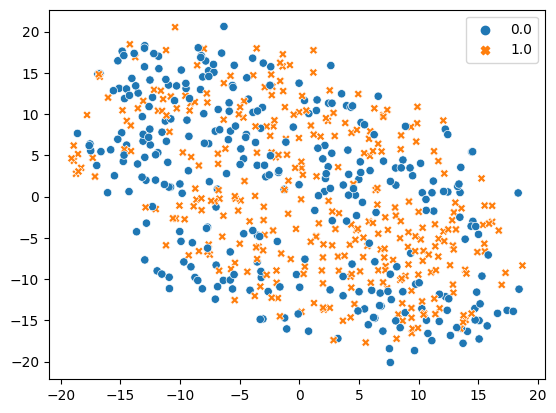

In [25]:
sns.scatterplot(x = z[:,0], y = z[:, 1], hue=ones_zeros, style=ones_zeros)
plt.show()

Прокомментируйте получившийся результат:

Ясно, что хочется получить – однородную смесь из точек красного и синего цветов. Ну что-то да получилось =)